# Comparing Tumor and Non-Tumor Acetylation Sites

# Step 1: Import necessary data and tools

Here we import the data we will be working with as well as the tools that we need to process it.

In [1]:
import pandas as pd
import numpy as np
import scipy.stats
import statsmodels.stats.multitest
import matplotlib.pyplot as plt
import seaborn as sns
import CPTAC.Endometrial as en
import math

Welcome to the CPTAC data service package. This import contains
information about the package. In order to access a specific data set,
import a CPTAC subfolder by either 'import CPTAC.DataName' or 'from
CPTAC import DataName'.
Loading Endometrial CPTAC data:
Loading Dictionary...
Loading Clinical Data...
Loading Acetylation Proteomics Data...
Loading Proteomics Data...
Loading Transcriptomics Data...
Loading CNA Data...
Loading Phosphoproteomics Data...
Loading Somatic Mutation Data...

 ******PLEASE READ******
CPTAC is a community resource project and data are made available
rapidly after generation for community research use. The embargo
allows exploring and utilizing the data, but the data may not be in a
publication until July 1, 2019. Please see
https://proteomics.cancer.gov/data-portal/about/data-use-agreement or
enter embargo() to open the webpage for more details.


In [2]:
#Get acetylation data
acetyl = en.get_acetylproteomics()

In [3]:
#Show a list of clinical attributes that can be tested with acetylation data
list(en.get_clinical().columns)
clinical = en.get_clinical()

For this use case we want to compare tumor and non-tumor cells, and will therefore set the clinical attribute to "Proteomics_Tumor_Normal."

In [4]:
clinical_attribute = "Proteomics_Tumor_Normal"

# Step 2: Make Tumor and Non-Tumor Dataframes

In order to make our tumor and non-tumor dataframes, we first need to merged the acetylation data with our clinical attribute.

In [5]:
#Merge attribute with acetylation dataframe
merged1 = en.compare_clinical(acetyl, clinical_attribute)
merged1.head()

idx,Proteomics_Tumor_Normal,A2M-K1168,A2M-K1176,A2M-K135,A2M-K145,A2M-K516,A2M-K664,A2M-K682,AACS-K391,AAGAB-K290,...,ZSCAN31-K215,ZSCAN32-K659,ZW10-K634,ZYX-K24,ZYX-K25,ZYX-K265,ZYX-K272,ZYX-K279,ZYX-K533,ZZZ3-K117
S001,Tumor,NaN,1.080,NaN,NaN,NaN,NaN,NaN,NaN,0.461,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
S002,Tumor,NaN,0.477,NaN,NaN,NaN,NaN,NaN,NaN,1.770,...,-0.104,-0.80300,NaN,-0.988,-0.343,-0.307,NaN,-0.0955,NaN,NaN
S003,Tumor,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.815,...,NaN,NaN,NaN,-0.459,-1.170,NaN,NaN,-0.7050,0.089,NaN
S004,NaN,NaN,3.340,NaN,NaN,1.9155,0.566,NaN,NaN,NaN,...,NaN,-0.63600,NaN,0.223,-0.232,NaN,0.751,NaN,NaN,NaN
S005,Tumor,NaN,-0.608,NaN,NaN,-0.9190,NaN,NaN,NaN,NaN,...,-0.457,-0.00175,-0.33,NaN,-0.537,NaN,NaN,-0.3700,NaN,NaN


In [6]:
#Show possible variations of clinical_attribute
clinical[[clinical_attribute]]

,Proteomics_Tumor_Normal
idx,
S001,Tumor
S002,Tumor
S003,Tumor
S005,Tumor
S006,Tumor
S007,Tumor
S008,Tumor
S009,Tumor
S010,Tumor


Now we want to set our normal values to "normal," without any names or underscores before it in order to better compare them with tumor types. Because of the somewhat inaccurate nature of collecting data from myometrium samples, we will disregard data labeled "Myometrium_normal" and replace them with NaN values.

In [7]:
merged1.loc[merged1.Proteomics_Tumor_Normal == 'Adjacent_normal', 'Proteomics_Tumor_Normal'] = 'Normal'
merged1.loc[merged1.Proteomics_Tumor_Normal == 'Enriched_normal', 'Proteomics_Tumor_Normal'] = 'Normal'
merged1.replace('Myometrium_normal', np.nan, inplace = True) # Set 'Myometrium_normal' to NaN 

Now we will make our two dataframes with tumor data and normal cell data.

In [8]:
tumor = merged1.loc[merged1[clinical_attribute] == "Tumor"]
non_tumor = merged1.loc[merged1[clinical_attribute] == "Normal"]

# Step 3: Compare Data and Find Significant Sites

First we will establish a significant threshold to work with by dividing .05 by the number of acetylation sites we are working with. Then we use a t-test to compare intensities between tumor and non-tumor cells, and add any significant sites to a list.

In [9]:
threshold = .05 / len(merged1.columns) #Here we find the significant p-value that we want to work with
print("Threshold:", threshold)
significantTests = []
significantSites = []
sigSiteCount = 0
for num in range(1,len(merged1.columns)):
    site = merged1.columns[num]
    oneSite = merged1[[clinical_attribute, site]]
    ttestRes = scipy.stats.ttest_ind(tumor[site], non_tumor[site])
    if (ttestRes[1] < threshold): #Check if there is a significant enough difference between data points
        significantTests.append(ttestRes)
        significantSites.append(site)
        sigSiteCount += 1
print("Number of significant sites: ", sigSiteCount)

Threshold: 4.602780079167818e-06
Number of significant sites:  290


# Step 4: Print Significant Sites and Graph Results

Now that we have our list of significant sites, we can print it to see the sites that we want to work with.

In [10]:
print(significantSites)

['ACIN1-K359', 'ADIRF-K70', 'AHCYL1-K246', 'AK2-K181', 'ALB-K117', 'ALB-K130', 'ALB-K160', 'ALB-K161', 'ALB-K183', 'ALB-K186', 'ALB-K198', 'ALB-K236', 'ALB-K264', 'ALB-K298', 'ALB-K305', 'ALB-K310', 'ALB-K341', 'ALB-K36', 'ALB-K383', 'ALB-K396', 'ALB-K402', 'ALB-K413', 'ALB-K426', 'ALB-K44', 'ALB-K463', 'ALB-K549', 'ALB-K558', 'ALB-K581', 'ALB-K584', 'ALB-K588', 'ALB-K597', 'ALB-K88', 'ALB-K97', 'ALDOA-K384', 'ALDOA-K96', 'ANXA5-K309', 'ANXA5-K70', 'ANXA5-K76', 'ANXA5-K79', 'ANXA5-K97', 'ANXA6-K314', 'APCS-K162', 'APOA1-K131', 'APOA2-K77', 'ASH2L-K312', 'ASPN-K230', 'ATP5PF-K113', 'BGN-K219', 'BGN-K82', 'BRPF1-K902', 'CCAR2-K215', 'CCDC86-K225', 'CDK1-K33', 'COX17-K30', 'CREBBP-K1216', 'CREBBP-K1837', 'CSRP1-K112', 'CSRP1-K131', 'CSRP1-K161', 'CSRP1-K168', 'CSRP1-K84', 'CSTB-K30', 'CTTN-K87', 'CYB5R1-K167', 'DBI-K114', 'DBI-K116', 'DCN-K200', 'DCN-K280', 'DCN-K74', 'DDAH2-K51', 'DDX5-K40', 'DES-K193', 'DES-K240', 'DES-K339', 'DHX15-K17', 'DSP-K1593', 'EEF1A1-K179', 'EEF1A1-K392', 'EEF1

Now we can pick sites that we want to graph. Not all of the graphs will be shown here, but rather we selected two to show.

Ttest_indResult(statistic=-6.04242088478341, pvalue=1.3729943442296388e-08)


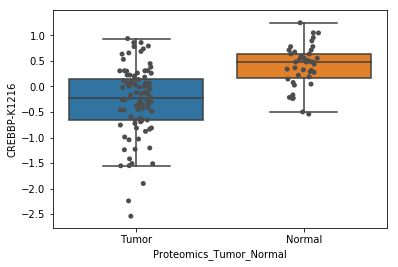

In [11]:
useSite = 'CREBBP-K1216'
print(scipy.stats.ttest_ind(tumor[useSite], non_tumor[useSite]))
sns.boxplot(x=clinical_attribute, y=useSite, data = merged1, showfliers = False)
sns.stripplot(x=clinical_attribute, y=useSite, data = merged1, color = '.3')

Ttest_indResult(statistic=5.046992457833309, pvalue=1.4123978531619245e-06)


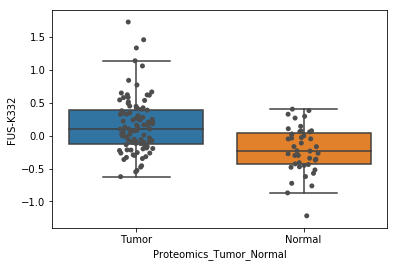

In [12]:
useSite = 'FUS-K332'
print(scipy.stats.ttest_ind(tumor[useSite], non_tumor[useSite]))
sns.boxplot(x=clinical_attribute, y=useSite, data = merged1, showfliers = False)
sns.stripplot(x=clinical_attribute, y=useSite, data = merged1, color = '.3')